<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/Epistemic_sets_2d_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Models — Interactive Notebook (Set-based & Probabilistic)

## What you will learn
- Build common epistemic uncertainty 2D sets (box / ball / ellipsoid / budgeted / convex hull)  

## How to use this notebook
1. Run the setup cell
2. In each section: change parameters → run the cell → interpret the plot
3. Answer the short questions (2–3 lines)

✅ Expected time: ~45–60 minutes

In [77]:
import numpy as np  # library for numerical computing
import matplotlib.pyplot as plt # library to plot and visualize results

def setup_ax(title="", lim=1.6):
    plt.figure()  # open figure
    plt.title(title)  # add title
    plt.axhline(0, linewidth=1)  # setup horiziontal line
    plt.axvline(0, linewidth=1)  # setup vertical line
    plt.xlim(-lim, lim)  # setup x and y limits
    plt.ylim(-lim, lim)
    plt.gca().set_aspect("equal", adjustable="box")  # adjust aspect ratio
    plt.grid(True)    # add a nice grid to the plot


def fill_polygon(x, y, alpha=0.2):
    plt.fill(x, y, alpha=alpha)   # ad a filled area with transparency given yb alpha =1:no-transparency alpha = 0: transparent
    plt.plot(x, y, linewidth=2)
print("✅ Setup complete")


✅ Setup complete


## Section X — [Name of uncertainty model]

**Idea (2–5 lines):**  
Explain what the set assumes.

**Try this:**  
Change one parameter and predict what will happen to the shape before running.

**Questions:**
1) What changed geometrically?  
2) What modelling assumption does this encode?


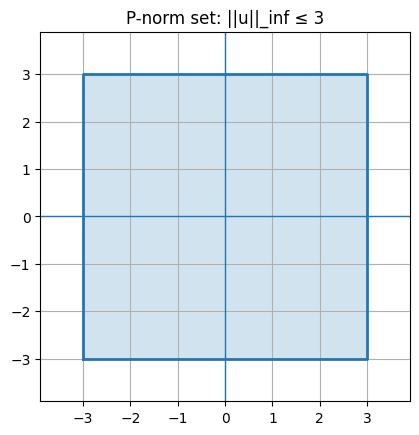

In [78]:
#@title P-norm uncertainty set (2D) — boundary only
p_choice = "inf"   #@param ["inf", "2", "1"]
r = 3          #@param {type:"slider", min:0.2, max:3.0, step:0.1}

setup_ax(title=f"P-norm set: ||u||_{p_choice} ≤ {r}", lim=r*1.3)

if p_choice == "inf":
    # box
    x = np.array([-r,  r,  r, -r, -r])
    y = np.array([-r, -r,  r,  r, -r])
    fill_polygon(x, y)

elif p_choice == "1":
    # diamond
    x = np.array([0,  r, 0, -r, 0])
    y = np.array([r,  0, -r, 0,  r])
    fill_polygon(x, y)

else:
    # circle
    t = np.linspace(0, 2*np.pi, 400)
    x = r*np.cos(t)
    y = r*np.sin(t)
    plt.fill(x, y, alpha=0.2)
    plt.plot(x, y, linewidth=2)

plt.show()



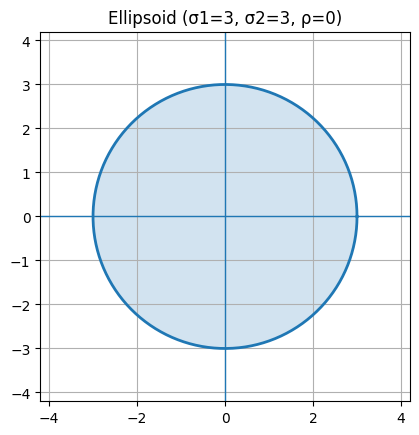

In [79]:
#@title Ellipsoidal set $u^T Σ u ≤ 1$ — boundary only
sigma1 = 3   #@param {type:"slider", min:0.2, max:3.0, step:0.1}
sigma2 = 3   #@param {type:"slider", min:0.2, max:3.0, step:0.1}
rho = 0      #@param {type:"slider", min:-0.95, max:0.95, step:0.05}

# Build a covariance-like matrix C and use its sqrt to map unit circle -> ellipse
C = np.array([[sigma1**2, rho*sigma1*sigma2],
              [rho*sigma1*sigma2, sigma2**2]])

# Ensure symmetric
C = 0.5*(C + C.T)

# Eigen-decomposition for stable sqrt
vals, vecs = np.linalg.eigh(C)
vals = np.maximum(vals, 1e-12)  # guard
C_sqrt = vecs @ np.diag(np.sqrt(vals)) @ vecs.T

t = np.linspace(0, 2*np.pi, 400)
circle = np.vstack([np.cos(t), np.sin(t)])  # unit circle
ellipse = (C_sqrt @ circle).T               # map to ellipse

lim = 1.4*max(sigma1, sigma2)
setup_ax(title=f"Ellipsoid (σ1={sigma1}, σ2={sigma2}, ρ={rho})", lim=lim)
plt.fill(ellipse[:,0], ellipse[:,1], alpha=0.2)
plt.plot(ellipse[:,0], ellipse[:,1], linewidth=2)
plt.show()


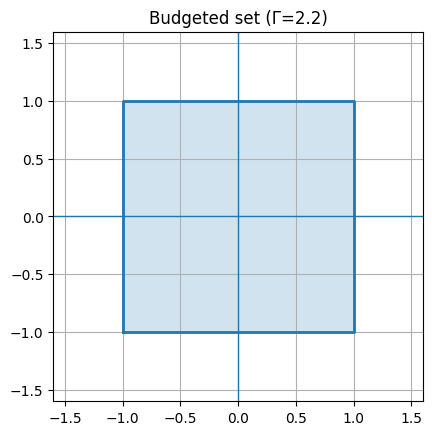

In [94]:
#@title Budgeted set: $||u||_∞ ≤ 1$ and $||u||_1 ≤ Γ$ — boundary only (2D)
Gamma = 2.2  #@param {type:"slider", min:0.5, max:2.5, step:0.05}
r_inf = 1.0

# Construct polygon by collecting all candidate vertices and keeping feasible ones,
# then ordering them by angle.

# --- Candidate vertices ---
candidates = []

# Diamond vertices (important when Γ <= 1)
candidates += [( Gamma, 0.0), (-Gamma, 0.0), (0.0,  Gamma), (0.0, -Gamma)]

# Box corners (important when Γ >= 2)
for x in (-r_inf, r_inf):
    for y in (-r_inf, r_inf):
        candidates.append((x, y))

# Intersections of |x|+|y|=Γ with box edges x=±1, y=±1
for x in (-r_inf, r_inf):
    y = Gamma - abs(x)
    if y >= 0:
        candidates += [(x, y), (x, -y)]
for y in (-r_inf, r_inf):
    x = Gamma - abs(y)
    if x >= 0:
        candidates += [(x, y), (-x, y)]

# --- Feasibility filter ---
feas_list = []
for x, y in candidates:
    if (max(abs(x), abs(y)) <= r_inf + 1e-12) and ((abs(x) + abs(y)) <= Gamma + 1e-12):
        feas_list.append((x, y))

# Force shape (N,2) even if empty
feas = np.array(feas_list, dtype=float).reshape(-1, 2)

# Remove duplicates safely
if feas.shape[0] > 0:
    feas = np.unique(feas, axis=0)

# Need at least 3 points to make a polygon
if feas.shape[0] < 3:
    setup_ax(title=f"Budgeted set (Γ={Gamma}) — too small to polygonize", lim=1.6)
    plt.text(0, 0, "Not enough vertices.\nIncrease Γ.", ha="center", va="center")
    plt.show()
else:
    # Order vertices around centroid
    cent = feas.mean(axis=0)
    angles = np.arctan2(feas[:, 1] - cent[1], feas[:, 0] - cent[0])
    order = np.argsort(angles)
    poly = feas[order]
    poly = np.vstack([poly, poly[0]])  # close polygon

    setup_ax(title=f"Budgeted set (Γ={Gamma})", lim=1.6)
    plt.fill(poly[:, 0], poly[:, 1], alpha=0.2)
    plt.plot(poly[:, 0], poly[:, 1], linewidth=2)
    plt.show()


In [ ]:
#@title Functional set: $U = \{u : g(u;\theta) ≤ 0\}$ — boundary + fill (no samples)
theta = 0.5      #@param {type:"slider", min:0, max:4.0, step:0.5}
res = 200
lim =3
# Example g(u): a nonlinear "peanut" / non-elliptic shape
# Feel free to replace with YOUR g(u).
def g(u1, u2):
    return (theta*(u1-u2)**2 + u2**2 - 1.0) * (u1**2 + u2**2 - 0.3) + 0.15*u1

x = np.linspace(-lim, lim, res)
y = np.linspace(-lim, lim, res)
X, Y = np.meshgrid(x, y)
G = g(X, Y)

setup_ax(title="Functional set: g(u) ≤ 0", lim=lim)
plt.contourf(X, Y, G, levels=[-1e9, 0], alpha=0.2)     # fill g<=0
plt.contour(X, Y, G, levels=[0], linewidths=2)         # boundary g=0
plt.show()
